# ВВП Ганы

In [232]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook')
# sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Загрузка данный и первичный анализ

In [233]:
df = pd.read_csv('data/ghana_gdp.zip', parse_dates=['year'], index_col='year')
df.columns = ['GDP']
df.index.freq = 'YS'
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Freq: AS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


In [234]:
df

GDP
year                     
1960-01-01  1217086834.73
1961-01-01           0.00
1962-01-01  1382352941.18
1963-01-01  1540616246.50
1964-01-01  1731092436.97
...                   ...
2017-01-01 60406382898.52
2018-01-01 67299280679.56
2019-01-01 68337537815.77
2020-01-01 70043199813.69
2021-01-01 77594279054.88

[62 rows x 1 columns]

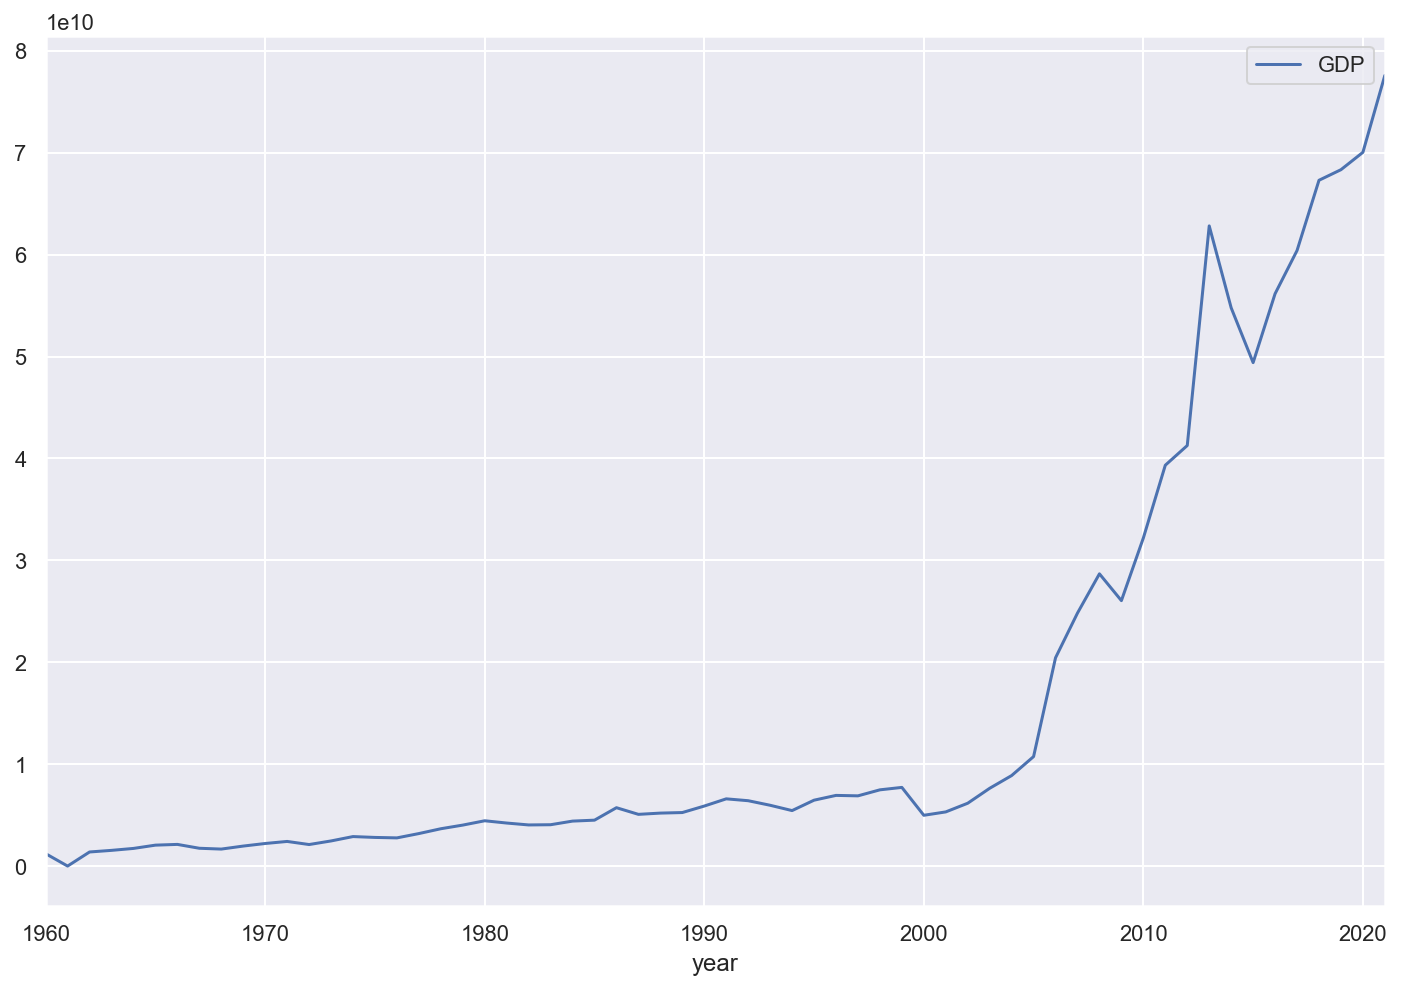

In [235]:
df.plot();

На графике виден экспоненциальный рост

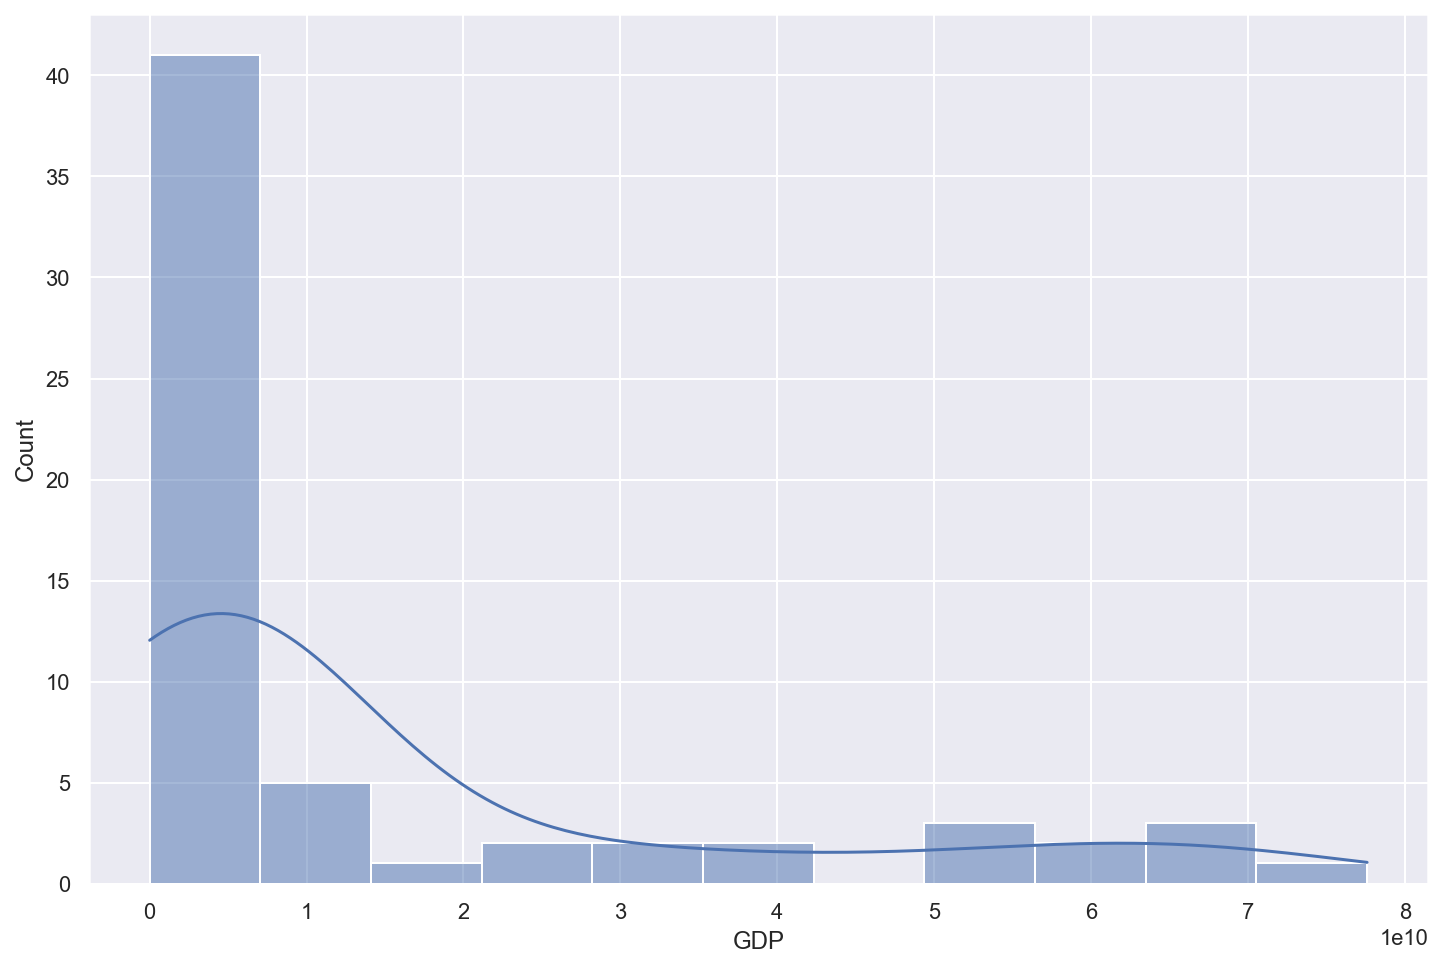

In [236]:
sns.histplot(df['GDP'], kde=True);

Распределение похоже на лог-нормальное

# Разделение выборки

In [237]:
test_period = 3 # последние три года оставляю для теста
train_df, test_df = df.iloc[:-test_period].copy(), df.iloc[-test_period:].copy()

### Произвожу декомпозицию

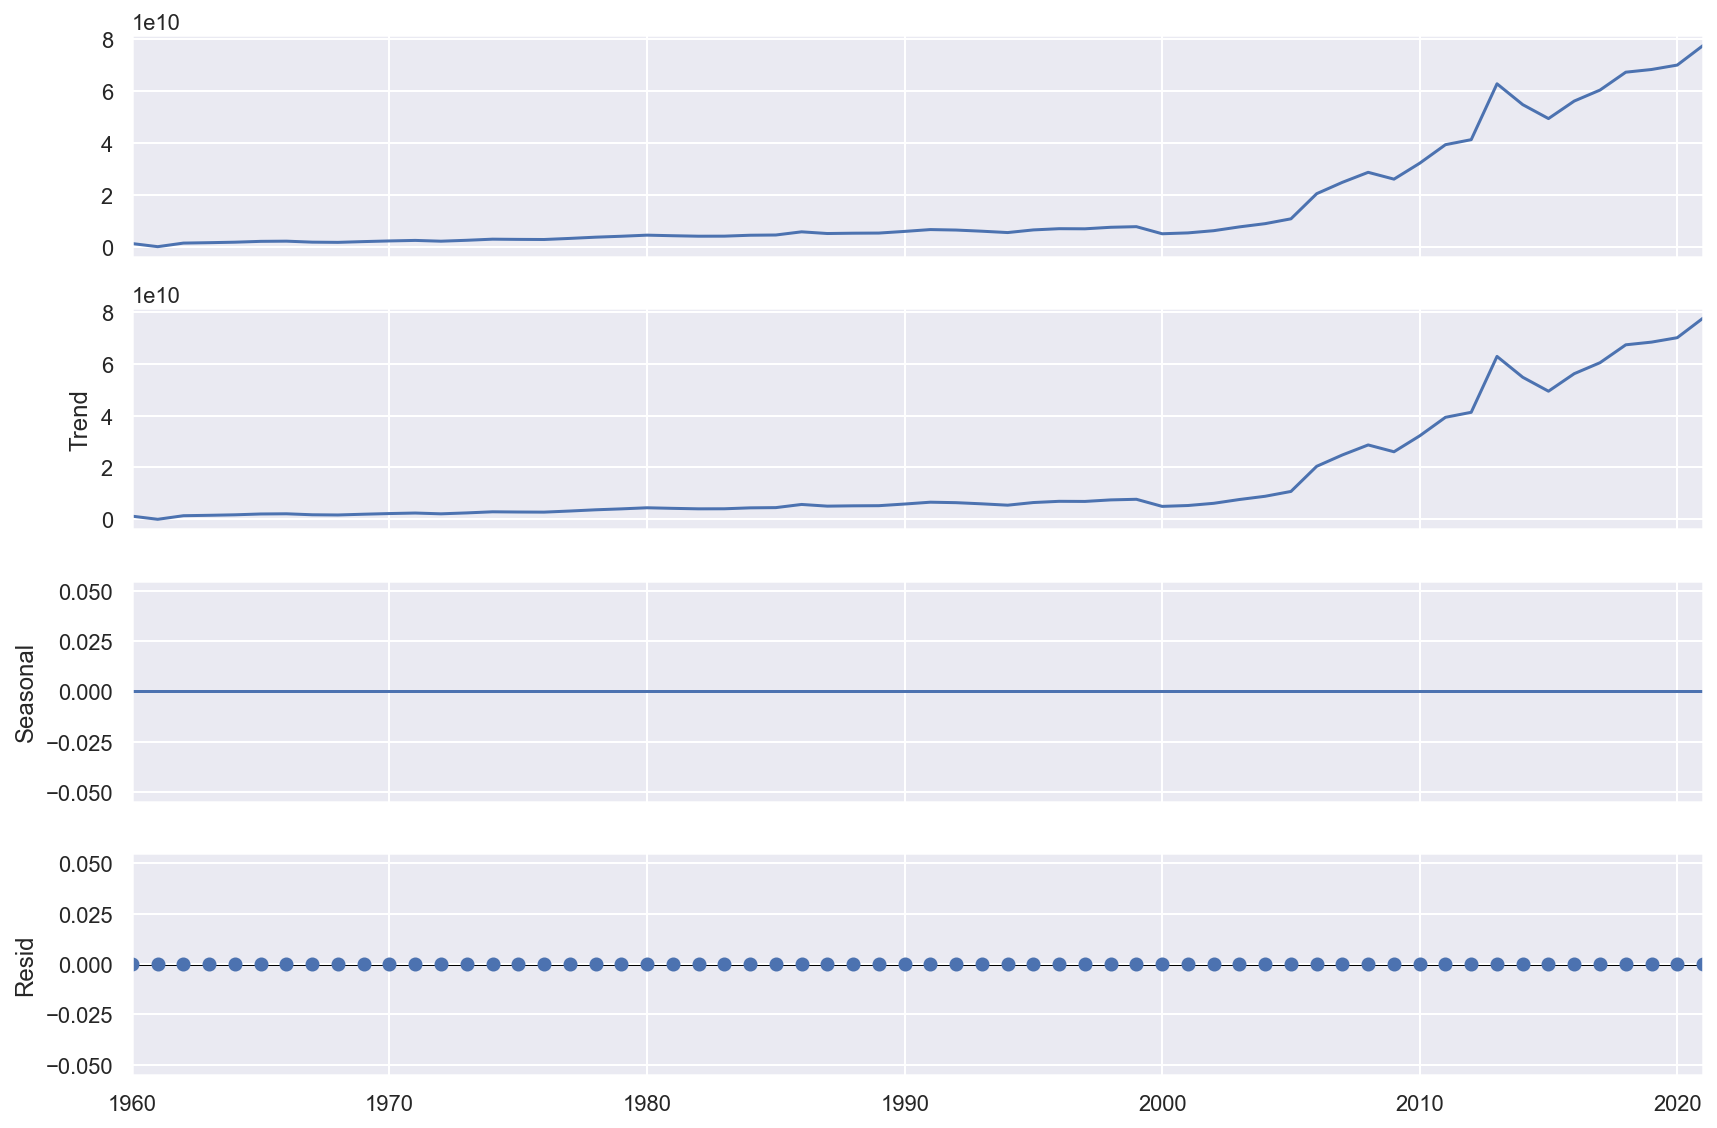

In [238]:
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

- Трендовая компонента не сильно отличается от исходного ряда, тренд есть
- Сезонная компонента отсутствует
- Шум нулевой, что странно

### Визуализация MA
Строю 3х летний краткосрочный цикл и 10ти летний долгосрочный

In [239]:
df_for_plot = df.copy()
df_for_plot['ma_3'] = df_for_plot['GDP'].rolling(3).mean()
df_for_plot['ma_10'] = df_for_plot['GDP'].rolling(10).mean()

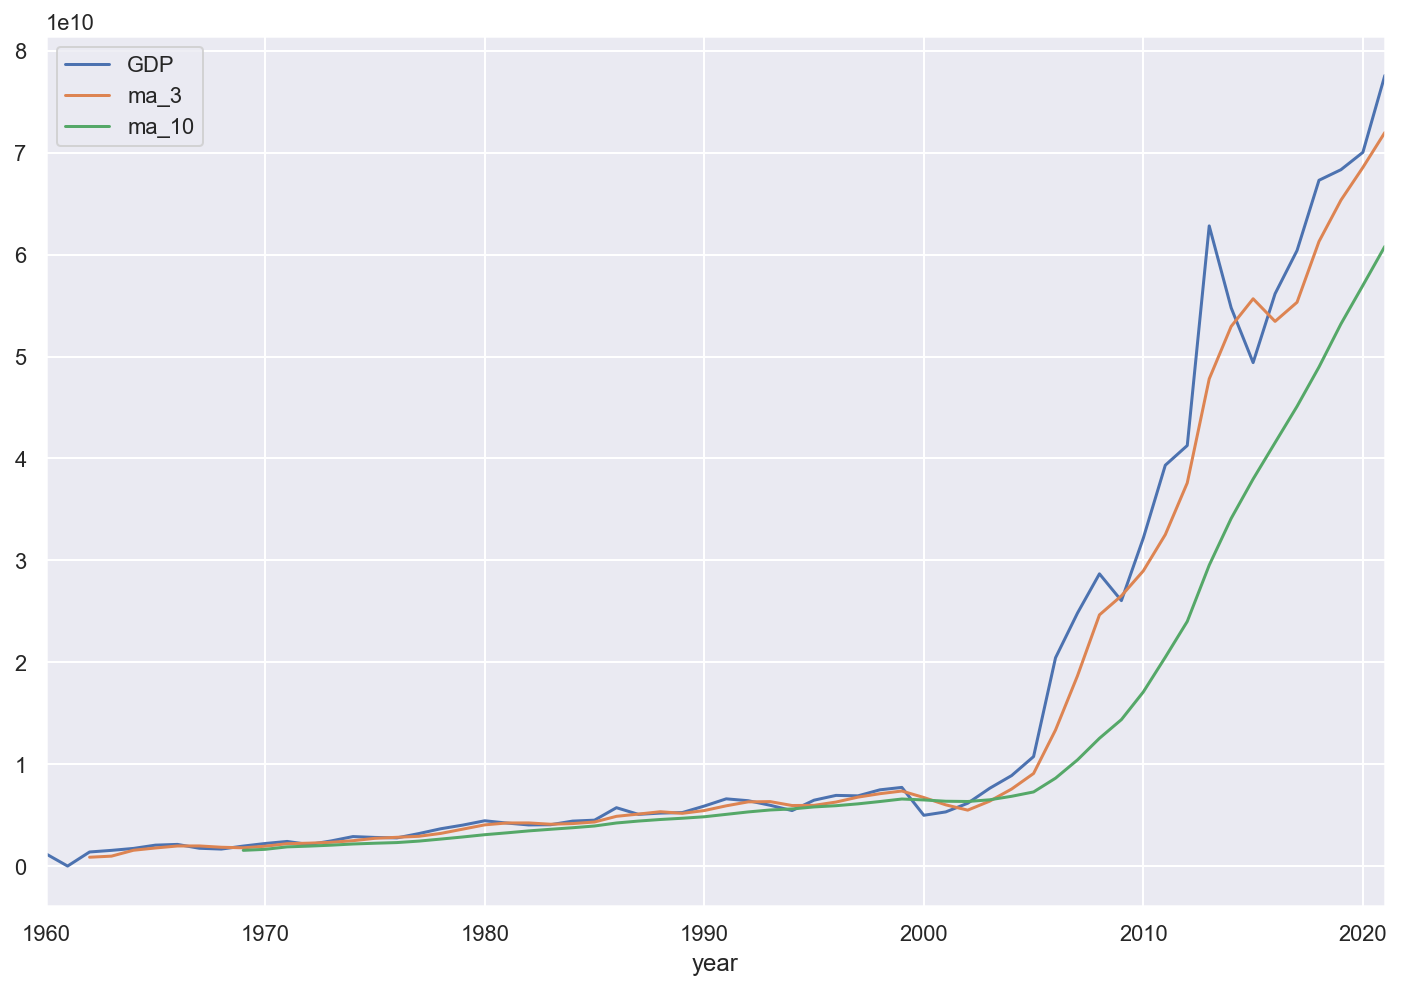

In [240]:
df_for_plot.plot();

# Проверка стационарности

In [241]:
def adf(x, threshold=0.05):
    '''
    Тест стационарности Augmented Dickey-Fuller Test(ADF Test)

    Args:
        x: Вектор значений переданный для проверки на стационарность
        threshold: Уровень достоверности, по умолчанию 5%

    Returns:
    '''

    _, pvalue = adfuller(x)[0], adfuller(x)[1]

    print('Test-Statistic:', _)
    print('P-Value:', pvalue)

    # The null hypothesis of the ADF test is that the time series is non-stationary.
    H0 = 'Time series is non-stationary'
    Ha = 'Time series is stationary!'

    if pvalue <= threshold: # Reject the null hypothesis
        print(Ha)
    else:
        print(H0)

### Проверка на стационарность

In [242]:
adf(df['GDP'])

Test-Statistic: 2.373839356148917
P-Value: 0.9989974617734
Time series is non-stationary


Ряд не стационарен, дифференцирую

In [243]:
gdp_diff = df['GDP'].diff().dropna()
adf(gdp_diff)

Test-Statistic: -1.587944111800476
P-Value: 0.4896467177743541
Time series is non-stationary


Дифференцирую второй раз

In [244]:
gdp_diff = gdp_diff.diff().dropna()
adf(gdp_diff)

Test-Statistic: -1.745908762849135
P-Value: 0.40762748326075393
Time series is non-stationary


Дифференцирую третий раз, ряд по прежнему нестационарен

In [245]:
gdp_diff = gdp_diff.diff().dropna()
adf(gdp_diff)

Test-Statistic: -5.278476343687468
P-Value: 6.066691711555073e-06
Time series is stationary!


Ряд стал стационарным после третьего дифференцирования, значение d = 3

In [246]:
d = 3

### Изучаю коррелограммы

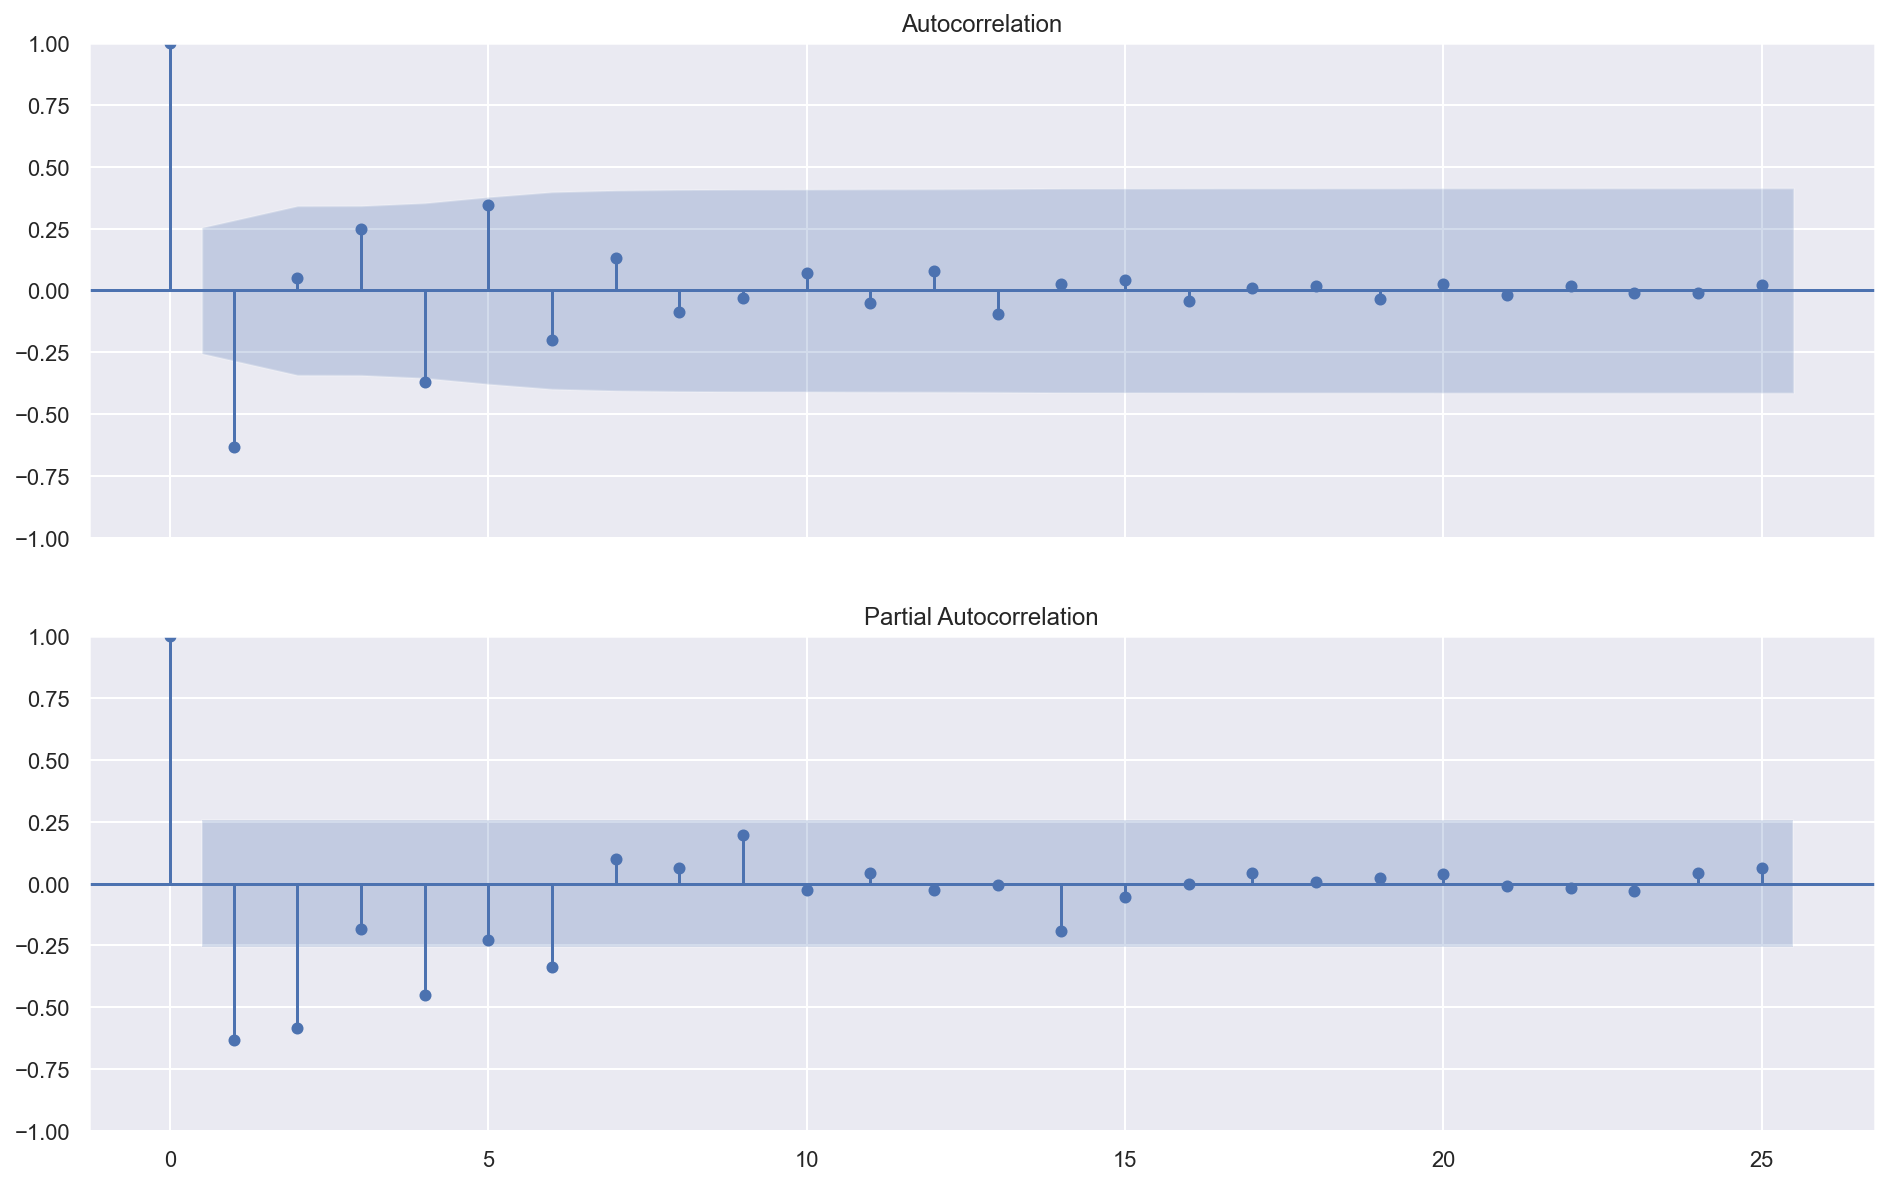

In [247]:
lags = 25
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

plot_acf(gdp_diff, lags=lags, ax=ax[0])
plot_pacf(gdp_diff, lags=lags, ax=ax[1])
plt.show();

По графику автокорреляции выбриаю значение q = 1

По графику частичной автокорреляции выбираю значение p = 2

In [248]:
q = 1
p = 2

In [249]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP'], order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 28 Jul 2023   AIC                           2659.231
Time:                        12:24:29   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

На графике частичной автокорреляции есть еще одно значение дальше, последне значимое p = 6

In [250]:
p = 6
arima_model = ARIMA(train_df['GDP'], order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.570
Date:                Fri, 28 Jul 2023   AIC                           2629.140
Time:                        12:24:29   BIC                           2645.343
Sample:                    01-01-1960   HQIC                          2635.422
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3723      0.072    -19.184      0.000      -1.513      -1.232
ar.L2         -1.7074      0.156    -10.942      0.000      -2.013      -1.402
ar.L3         -1.5726      0.205     -7.658      0.000      -1.975      -1.170
ar.L4         -1.6483      0.141    -11.714      0.000      -1.924      -1.373
ar.L5         -1.2768      0.159     -8.021      0.000      -1.589      -0.965
ar.L6         -0.8853      0.148     -5.974      0.000      -1.176      -0.595
ma.L1         -0.5920      0.104     -5.673      0.000      -0.796      -0.387
sigma2      8.567e+18   3.66e-20   2.34e+38      0.000    8.57e+18    8.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                73.04
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              76.70   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.62e+54. Standard errors may be unstable.
"""

AIC для модели с p=6 ниже, выбираю ее

In [251]:
arima_pred = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
arima_pred

2019-01-01   69025971178.67
2020-01-01   77302051563.51
2021-01-01   64770758740.84
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [252]:
pred_df = pd.DataFrame(index=df.index)

pred_df['model_preds'] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['GDP'] = df['GDP']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, 'model_preds_lower'] = forecast_df['lower GDP']
pred_df.at[test_df.index, 'model_preds_upper'] = forecast_df['upper GDP']

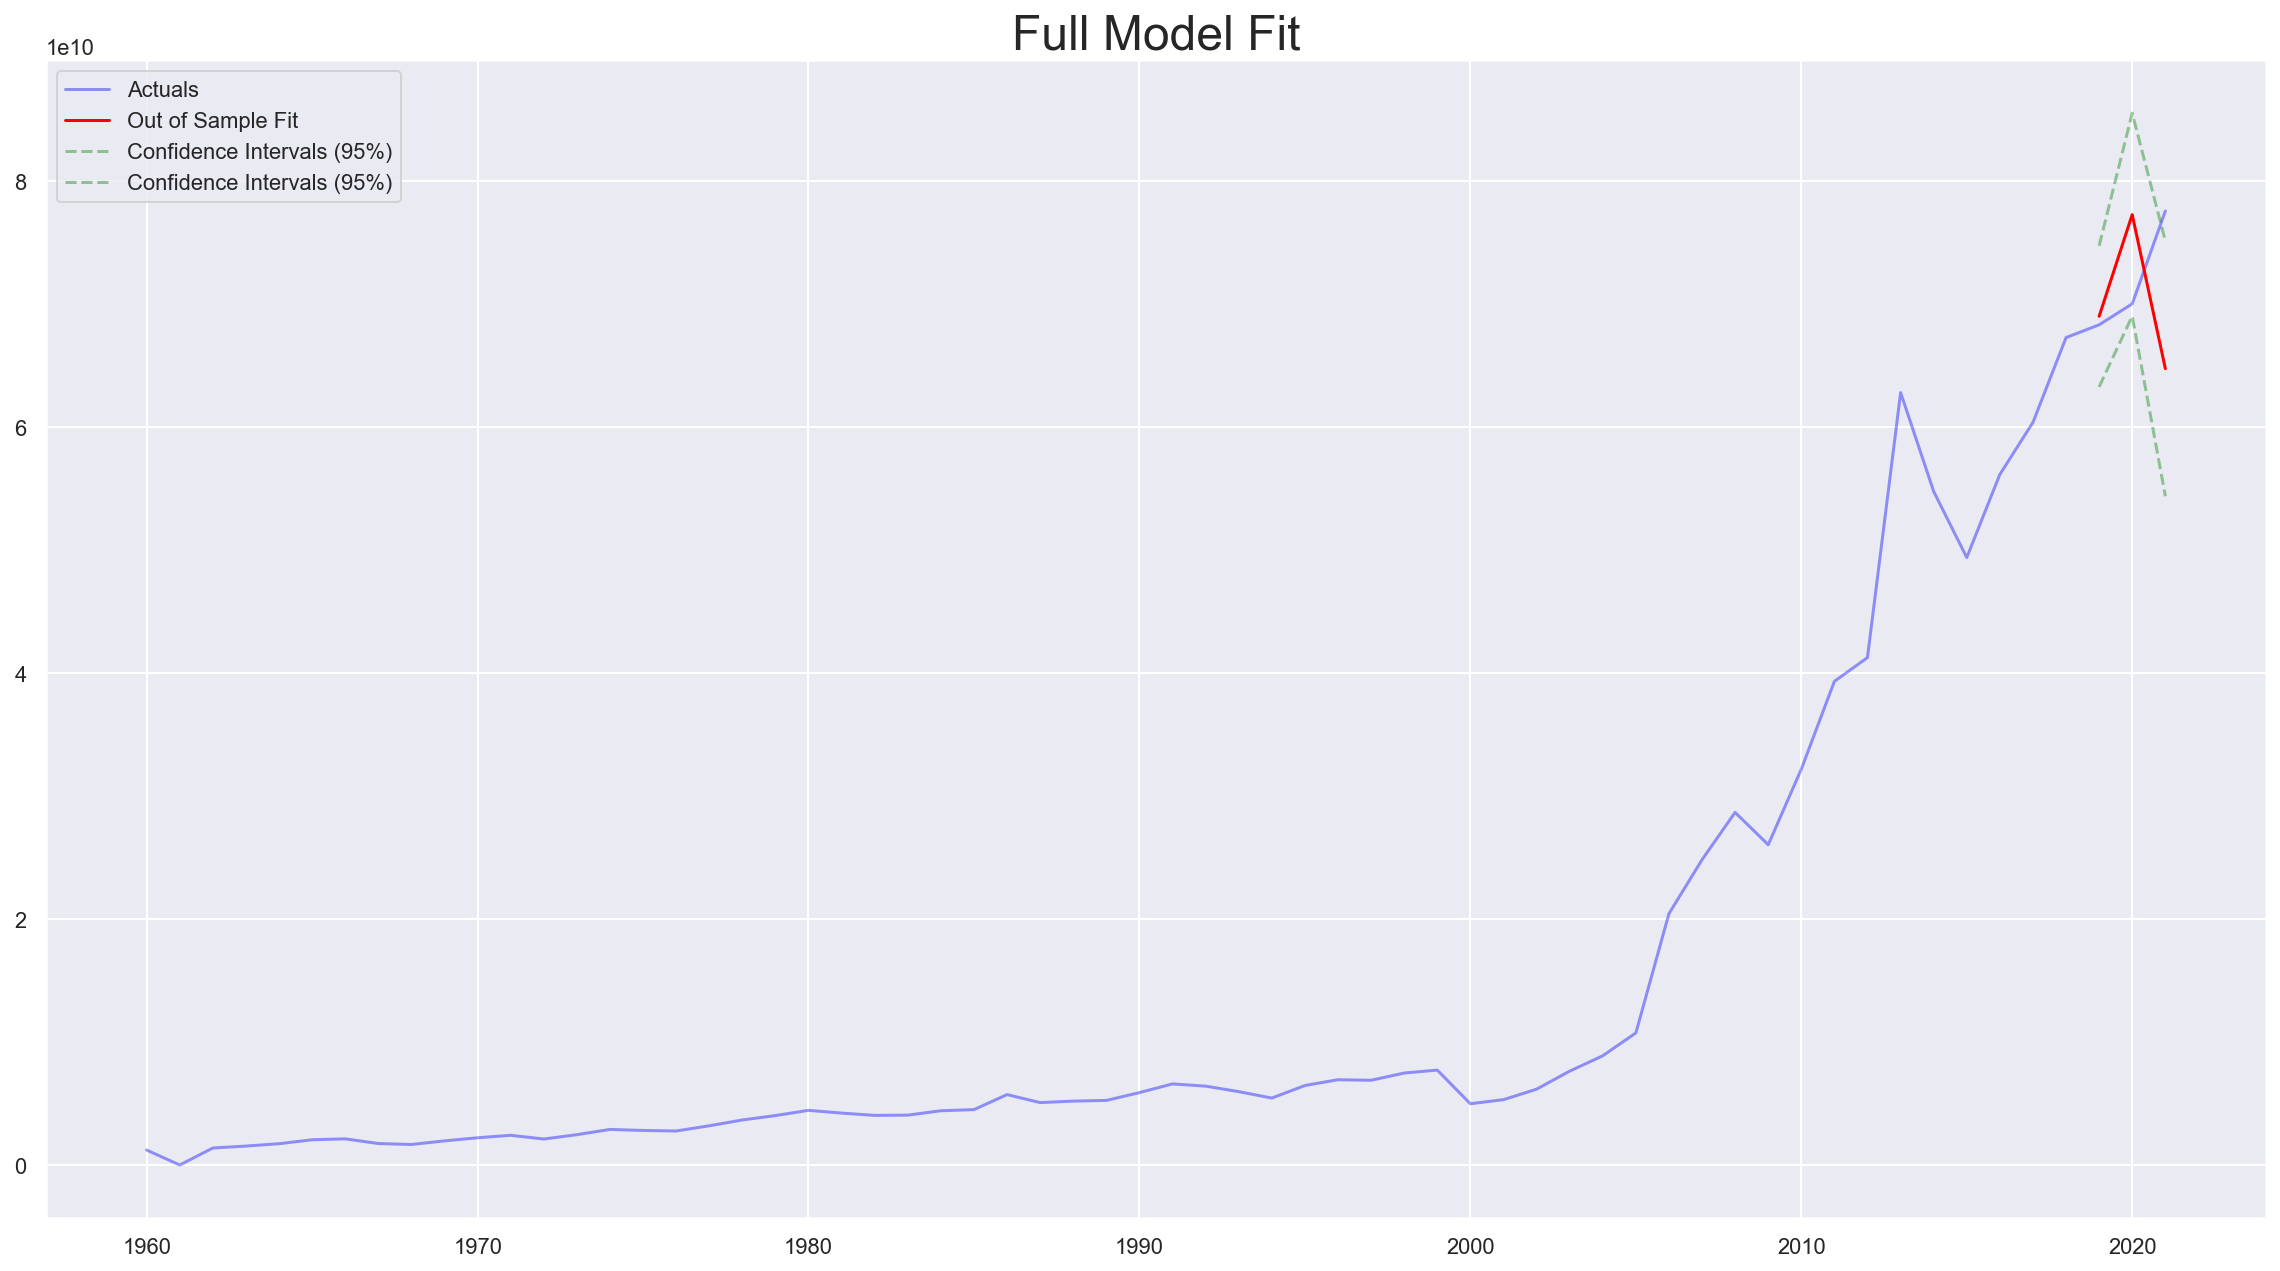

In [253]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(pred_df['GDP'], color='blue', label='Actuals', alpha=0.4)

ax.plot(
    pred_df.loc[test_df.index]['model_preds'],
    color='red',
    label='Out of Sample Fit',
)

ax.plot(
    pred_df.loc[test_df.index][['model_preds_lower', 'model_preds_upper']],
    color='green',
    linestyle='--',
    label='Confidence Intervals (95%)',
    alpha=0.4,
)

plt.title('Full Model Fit', size=24)
plt.tight_layout()
plt.legend()
plt.show()

In [254]:
# !pip install pmdarima

In [255]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    d=3,
    max_p=8,
    max_q=8,
    test='adf',
    error_action='ignore',
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.04 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.05 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.04 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.657 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 28 Jul 2023   AIC                           2659.231
Time:                        12:24:31   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

Незнаю почему, но автоперебор параметров не нашел результат, что я нашел вручную

# Обработка пропусков

In [256]:
df[df['GDP'] == 0]

GDP
year           
1961-01-01 0.00

В данных есть пропуск в виде нулевого значения. 

Понятно что ВВП не мог быть нулевым. 

Логично для такого типа данных заполнить этот пропуск средним значением по годам до и после пропусков.

In [257]:
df['GDP'] = df['GDP'].replace(0, np.nan)
df['GDP'] = df['GDP'].interpolate(method='linear')

# Разделение выборки

In [258]:
test_period = 3 # последние три года оставляю для теста
train_df, test_df = df.iloc[:-test_period].copy(), df.iloc[-test_period:].copy()

### Проверка на стационарность

In [259]:
adf(df['GDP'])

Test-Statistic: 2.380848757555631
P-Value: 0.99900101016983
Time series is non-stationary


Ряд не стационарен, дифференцирую

In [260]:
gdp_diff = df['GDP'].diff().dropna()
adf(gdp_diff)

Test-Statistic: -1.7397184892921593
P-Value: 0.41077316906677114
Time series is non-stationary


Дифференцирую второй раз

In [261]:
gdp_diff = gdp_diff.diff().dropna()
adf(gdp_diff)

Test-Statistic: -1.7042548913504119
P-Value: 0.4289215730117663
Time series is non-stationary


Дифференцирую третий раз, ряд по прежнему нестационарен

In [262]:
gdp_diff = gdp_diff.diff().dropna()
adf(gdp_diff)

Test-Statistic: -5.456208629828435
P-Value: 2.578324497204482e-06
Time series is stationary!


Ряд так же стал стационарным только по третьего дифференцирования, значение d = 3

### Изучаю коррелограммы

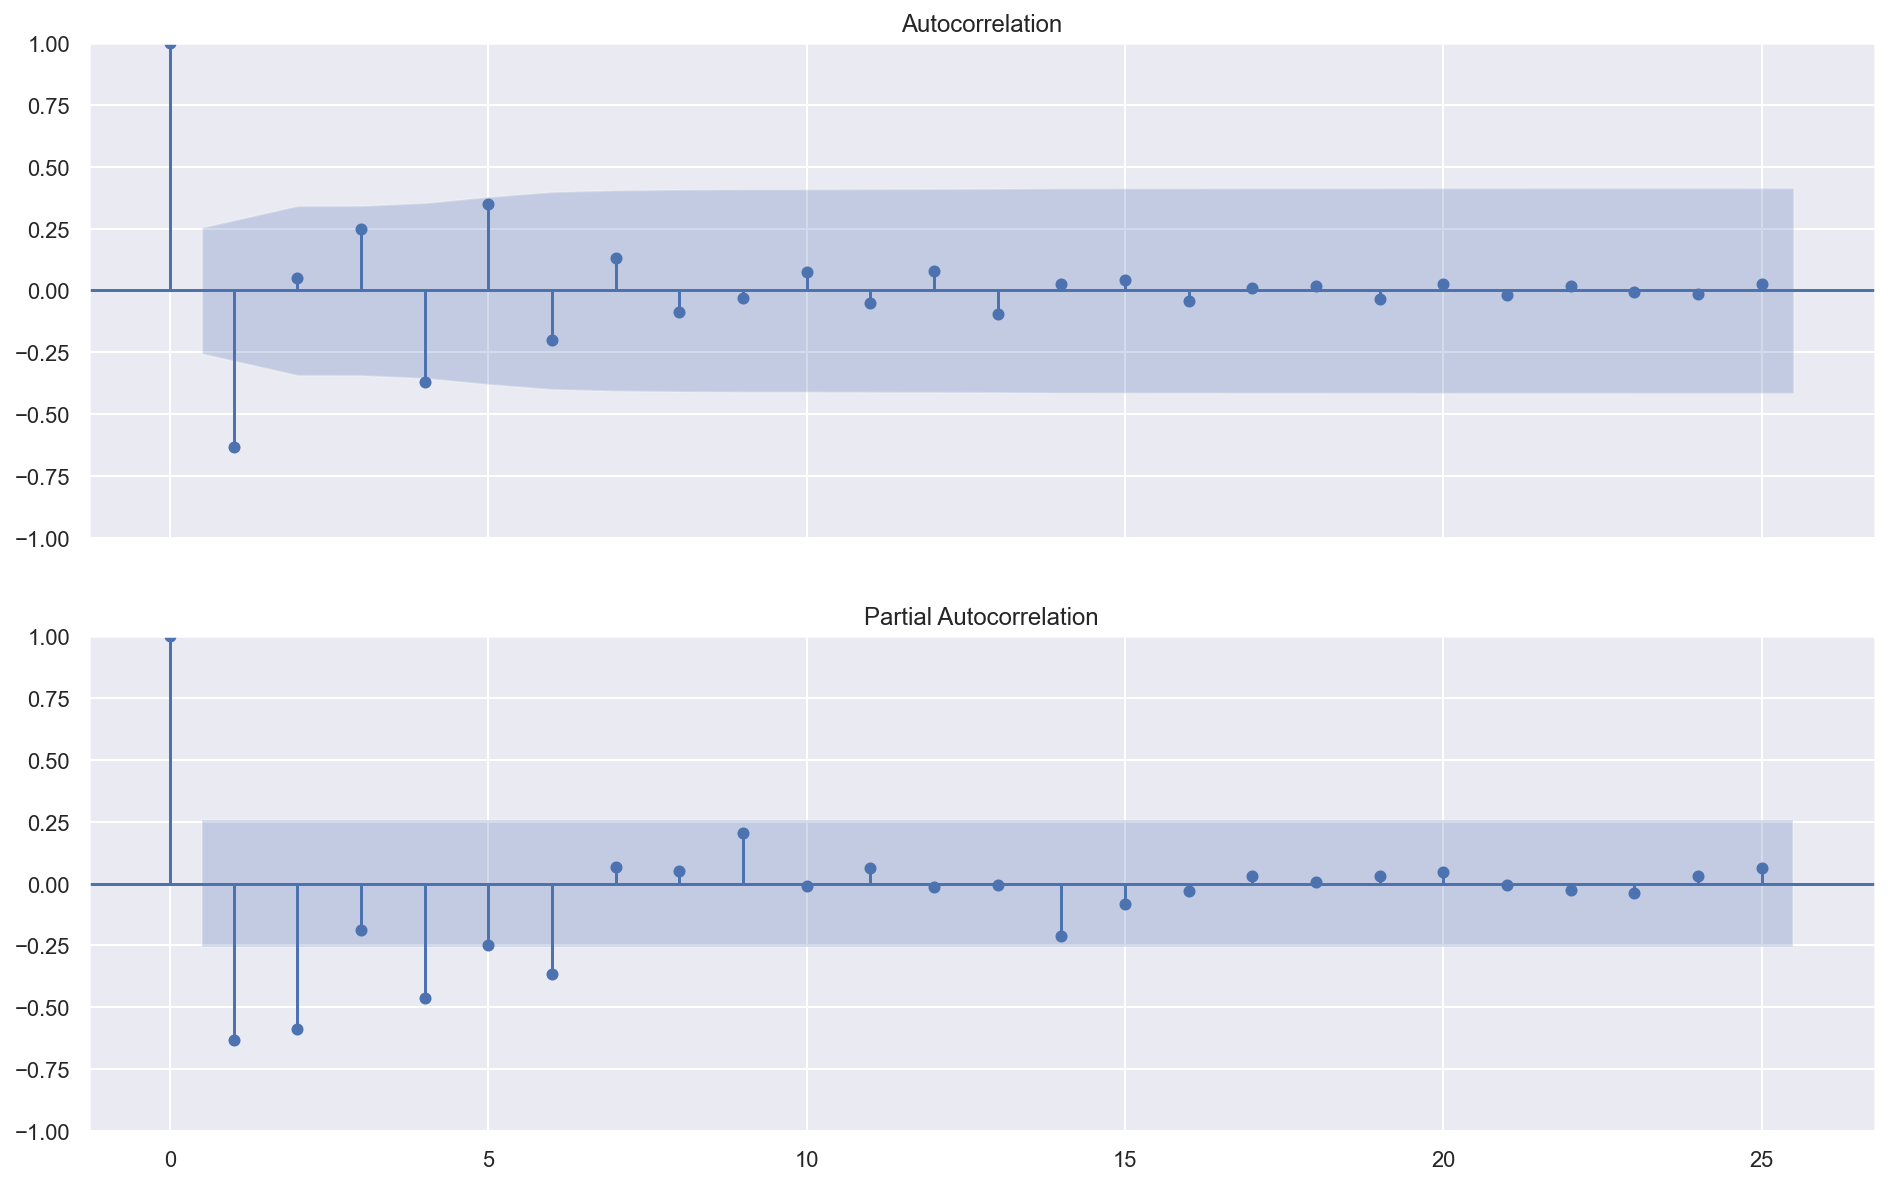

In [263]:
lags = 25
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

plot_acf(gdp_diff, lags=lags, ax=ax[0])
plot_pacf(gdp_diff, lags=lags, ax=ax[1])
plt.show();

По графику автокорреляции выбриаю значение q = 1

По графику частичной автокорреляции выбираю значение p = 6

In [264]:
q = 1
p = 6

In [265]:
arima_model = ARIMA(train_df['GDP'], order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.477
Date:                Fri, 28 Jul 2023   AIC                           2628.955
Time:                        12:24:31   BIC                           2645.157
Sample:                    01-01-1960   HQIC                          2635.236
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3720      0.070    -19.722      0.000      -1.508      -1.236
ar.L2         -1.7152      0.151    -11.394      0.000      -2.010      -1.420
ar.L3         -1.5816      0.197     -8.016      0.000      -1.968      -1.195
ar.L4         -1.6557      0.137    -12.060      0.000      -1.925      -1.387
ar.L5         -1.2760      0.157     -8.124      0.000      -1.584      -0.968
ar.L6         -0.8916      0.141     -6.340      0.000      -1.167      -0.616
ma.L1         -0.5844      0.105     -5.583      0.000      -0.789      -0.379
sigma2      8.426e+18   3.34e-20   2.52e+38      0.000    8.43e+18    8.43e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                76.24
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             120.88   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+54. Standard errors may be unstable.
"""

AIC стала чуть лучше (меньше) 2628.955, а было 2629.140

In [266]:
arima_pred = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
arima_pred

2019-01-01   68650942327.32
2020-01-01   77046555845.49
2021-01-01   64510510916.70
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [267]:
pred_df = pd.DataFrame(index=df.index)

pred_df['model_preds'] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['GDP'] = df['GDP']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, 'model_preds_lower'] = forecast_df['lower GDP']
pred_df.at[test_df.index, 'model_preds_upper'] = forecast_df['upper GDP']

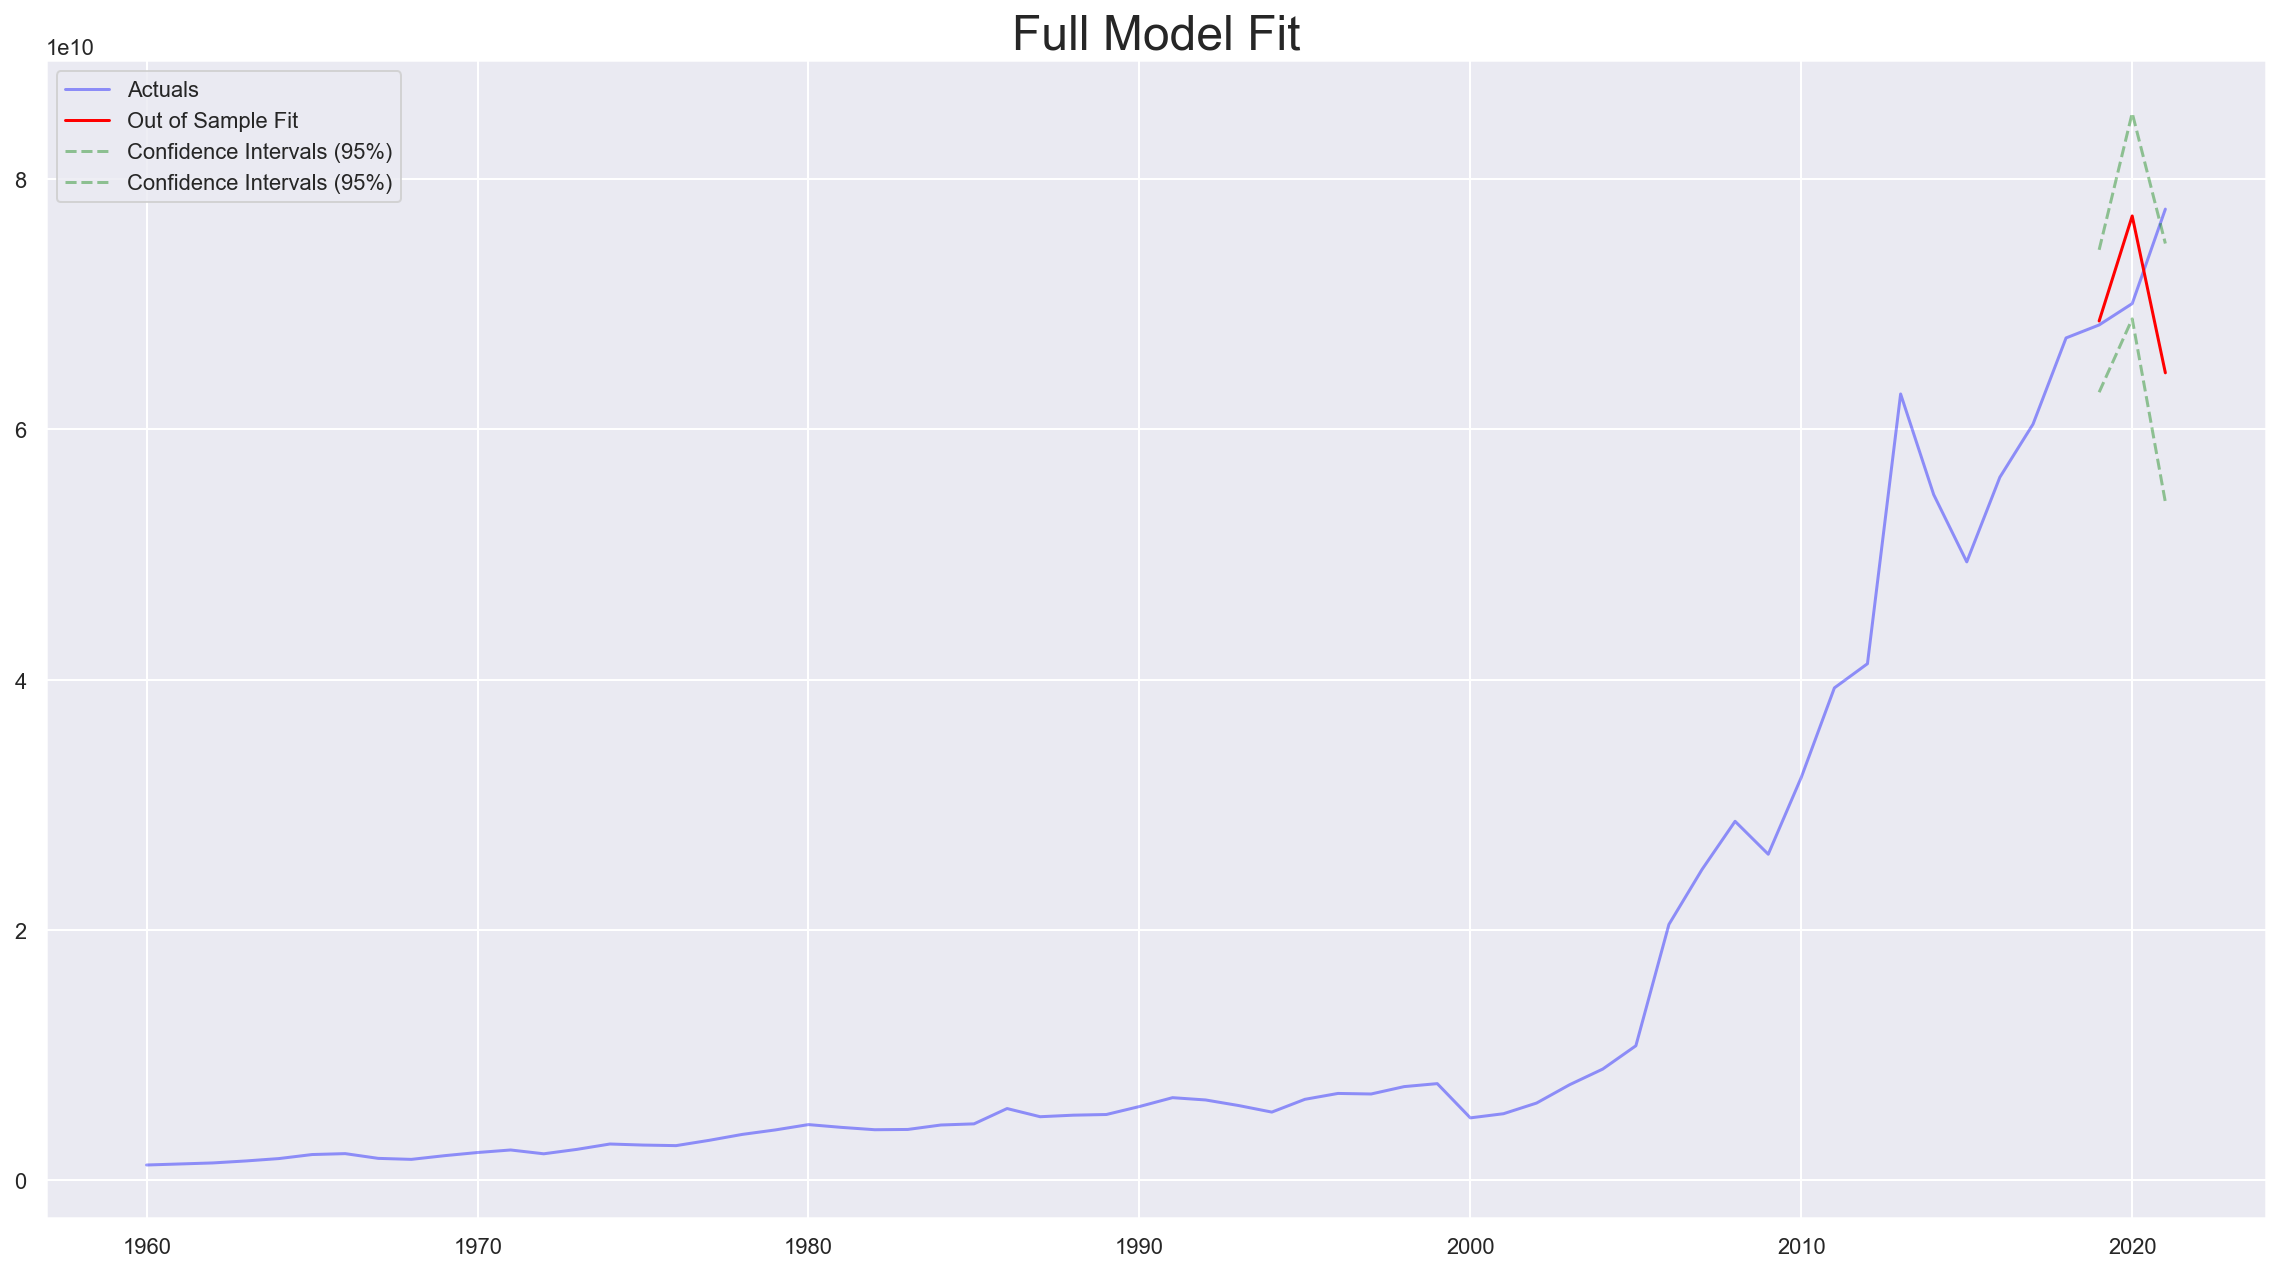

In [268]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(pred_df['GDP'], color='blue', label='Actuals', alpha=0.4)

ax.plot(
    pred_df.loc[test_df.index]['model_preds'],
    color='red',
    label='Out of Sample Fit',
)

ax.plot(
    pred_df.loc[test_df.index][['model_preds_lower', 'model_preds_upper']],
    color='green',
    linestyle='--',
    label='Confidence Intervals (95%)',
    alpha=0.4,
)

plt.title('Full Model Fit', size=24)
plt.tight_layout()
plt.legend()
plt.show()

Изменения незначительны, улучшения не видны невооруженным глазом.

# Волатильность

In [269]:
df['volatility'] = df['GDP'].pct_change().mul(100).abs()
df

GDP  volatility
year                                 
1960-01-01  1217086834.73         NaN
1961-01-01  1299719887.96        6.79
1962-01-01  1382352941.18        6.36
1963-01-01  1540616246.50       11.45
1964-01-01  1731092436.97       12.36
...                   ...         ...
2017-01-01 60406382898.52        7.55
2018-01-01 67299280679.56       11.41
2019-01-01 68337537815.77        1.54
2020-01-01 70043199813.69        2.50
2021-01-01 77594279054.88       10.78

[62 rows x 2 columns]

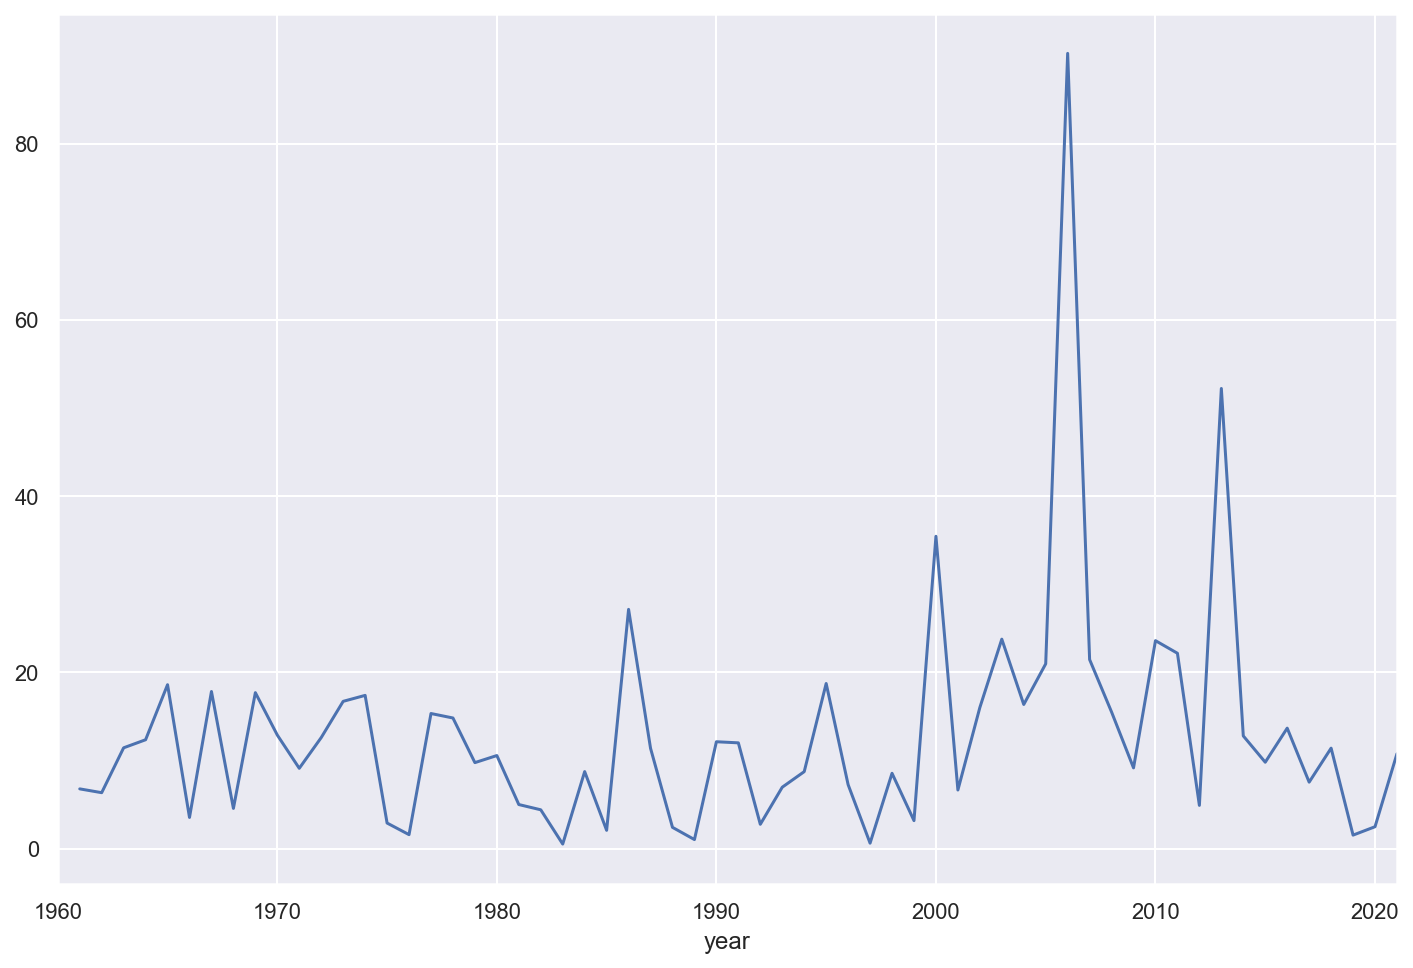

In [270]:
df['volatility'].plot();

In [271]:
test_period = 3 # последние три года оставляю для теста
train_df, test_df = df.iloc[:-test_period].copy(), df.iloc[-test_period:].copy()

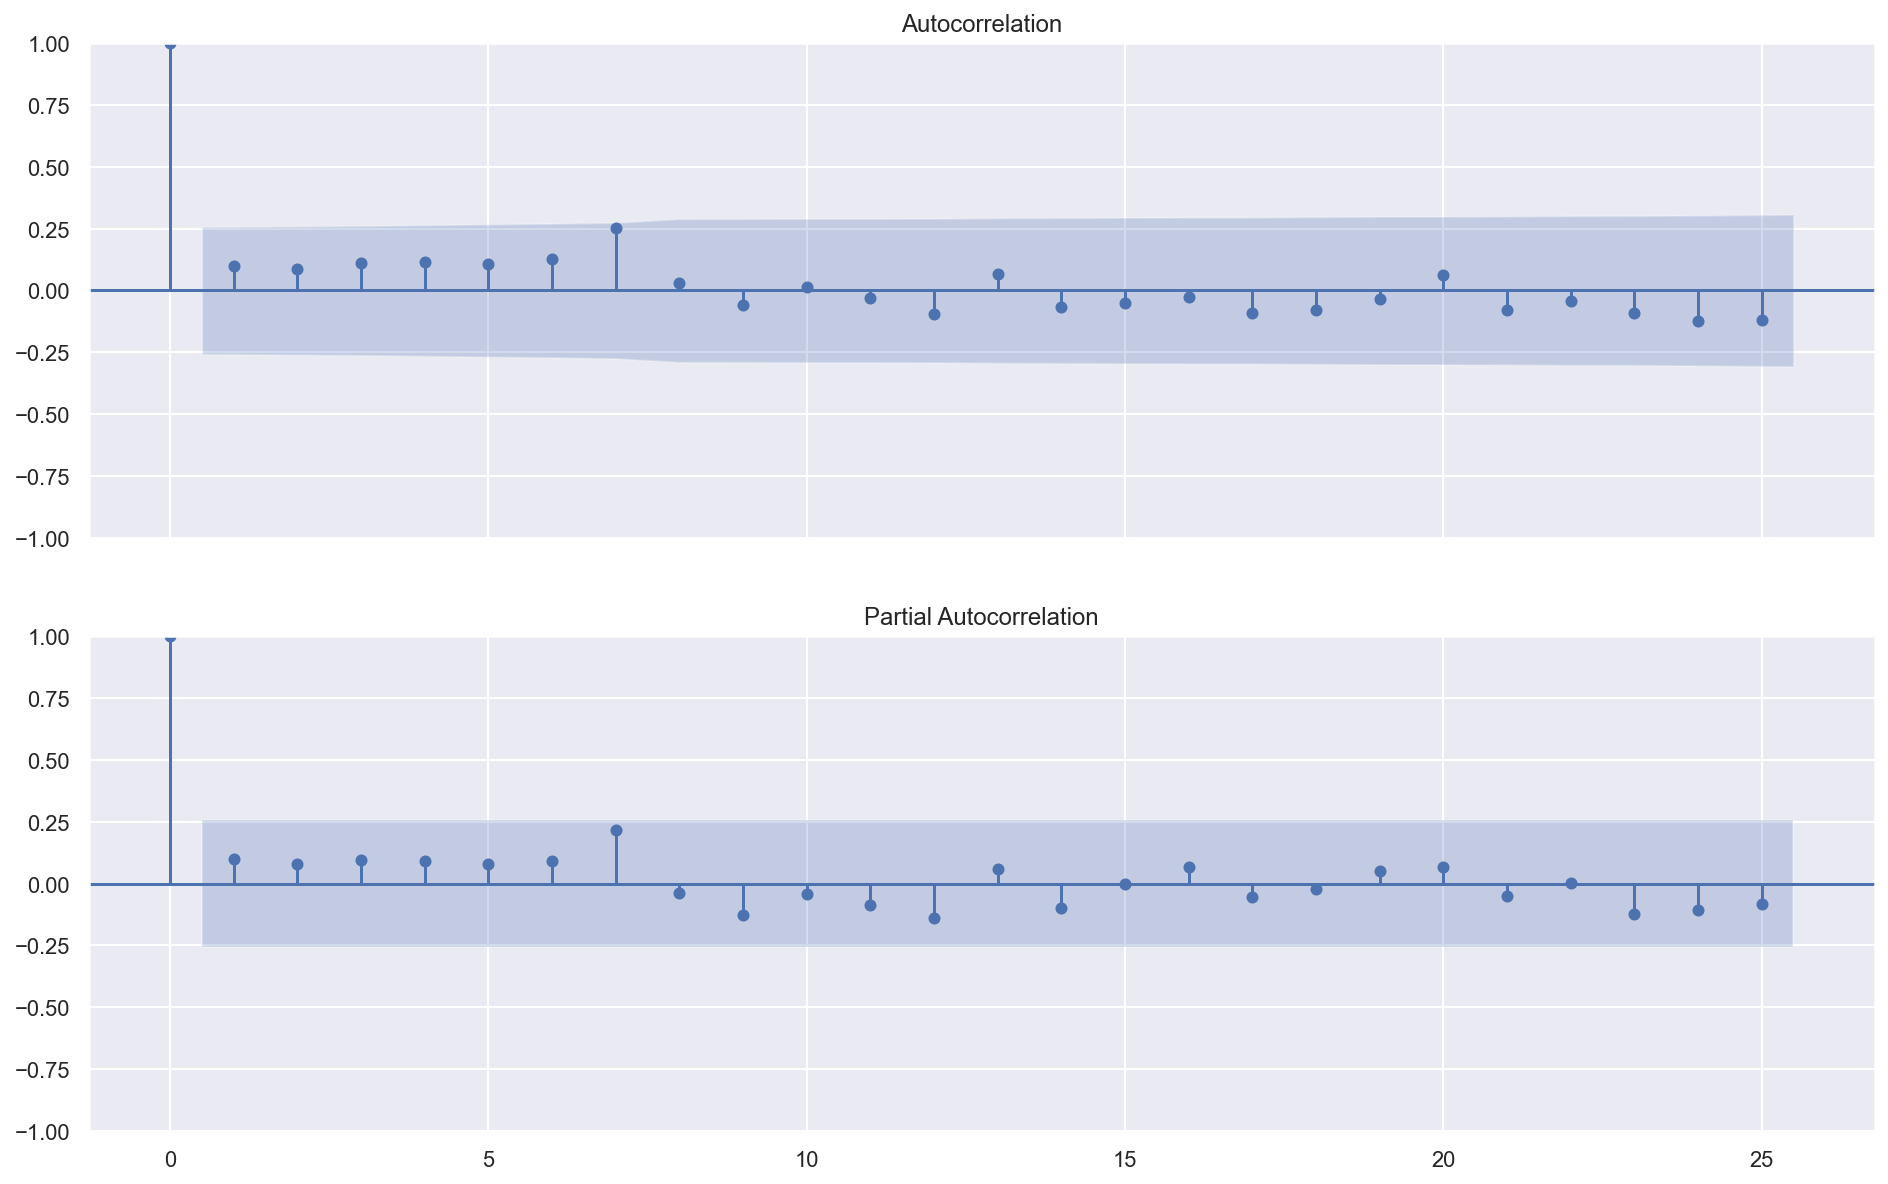

In [272]:
train_vol = train_df.volatility.dropna()
lags = 25

fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

plot_acf(train_vol, lags=lags, ax=ax[0])
plot_pacf(train_vol, lags=lags, ax=ax[1])
plt.show();

Пробую выбрать пик p=7, q=7 хотя они находится за границами достоверности.

In [273]:
adf(train_vol)

Test-Statistic: -6.725311059553779
P-Value: 3.4014596148856493e-09
Time series is stationary!


Ряд стационарен, дифференцирование не потребовалось d=0

In [274]:
df['volatility']

year
1960-01-01     NaN
1961-01-01    6.79
1962-01-01    6.36
1963-01-01   11.45
1964-01-01   12.36
              ... 
2017-01-01    7.55
2018-01-01   11.41
2019-01-01    1.54
2020-01-01    2.50
2021-01-01   10.78
Freq: AS-JAN, Name: volatility, Length: 62, dtype: float64

In [284]:
from arch import arch_model

p = 7
q = 7
for_garch = df['volatility'].dropna()

model = arch_model(for_garch, p=p, q=q)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


In [285]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Fri, Jul 28 2023   Df Residuals:                       57
Time:                        12:27:31   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

Формируем предсказание

In [286]:
predictions_df = test_df.copy()
predictions_df['Predictions'] = model_results.forecast().residual_variance.loc[test_df.index]

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


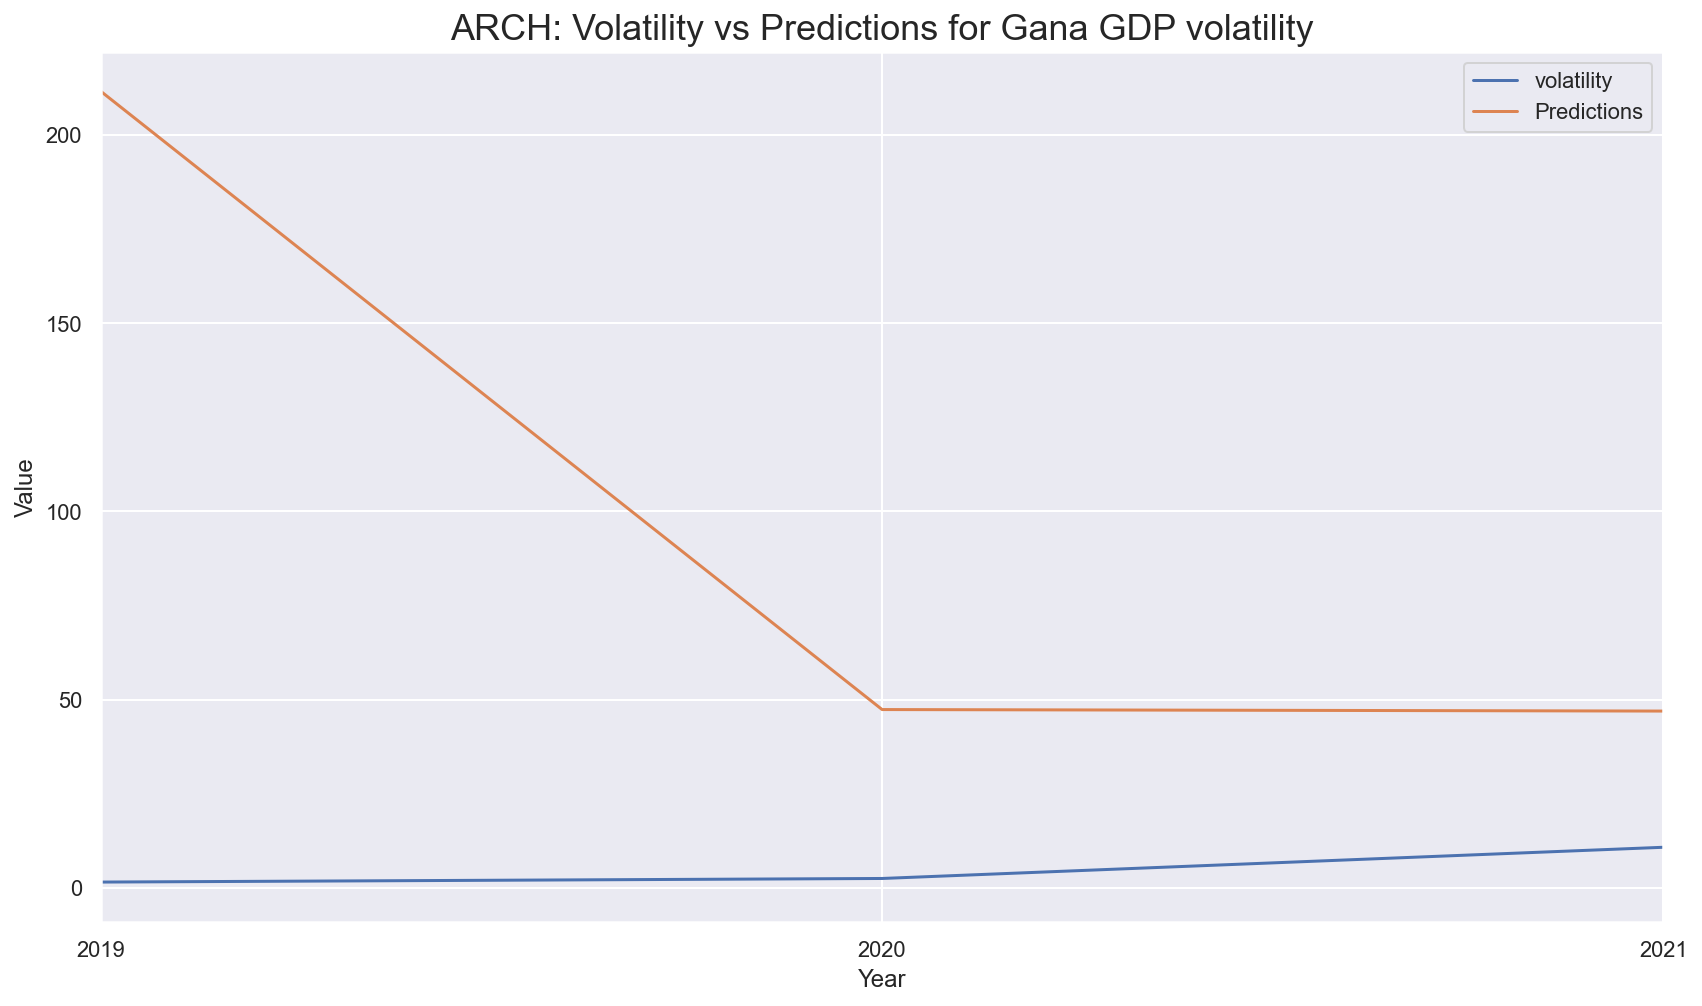

In [327]:
predictions_df[['volatility', 'Predictions']].plot(kind='line', figsize=(14, 8))
plt.title('ARCH: Volatility vs Predictions for Gana GDP volatility', size=18)
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

In [328]:
print(f"ARCH on test MSE: {mean_squared_error(predictions_df['volatility'], predictions_df['Predictions']):.2f}")

ARCH on test MSE: 15799.82


# Используем LinearRegression

### Разделение выборки

In [329]:
lr_df = df[['volatility']].dropna()
lr_df['time_step'] = range(len(lr_df))

test_period = 3 # последние три года оставляю для теста
train_df, test_df = lr_df.iloc[:-test_period].copy(), lr_df.iloc[-test_period:].copy()

X_train, y_train = train_df[['time_step']], train_df['volatility']
X_test, y_test = test_df[['time_step']], test_df['volatility']

In [330]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)

In [331]:
lr_prediction_df = pd.DataFrame(y_test)
lr_prediction_df['Predictions'] = y_test_pred
lr_prediction_df

volatility  Predictions
year                               
2019-01-01        1.54        19.82
2020-01-01        2.50        20.04
2021-01-01       10.78        20.25

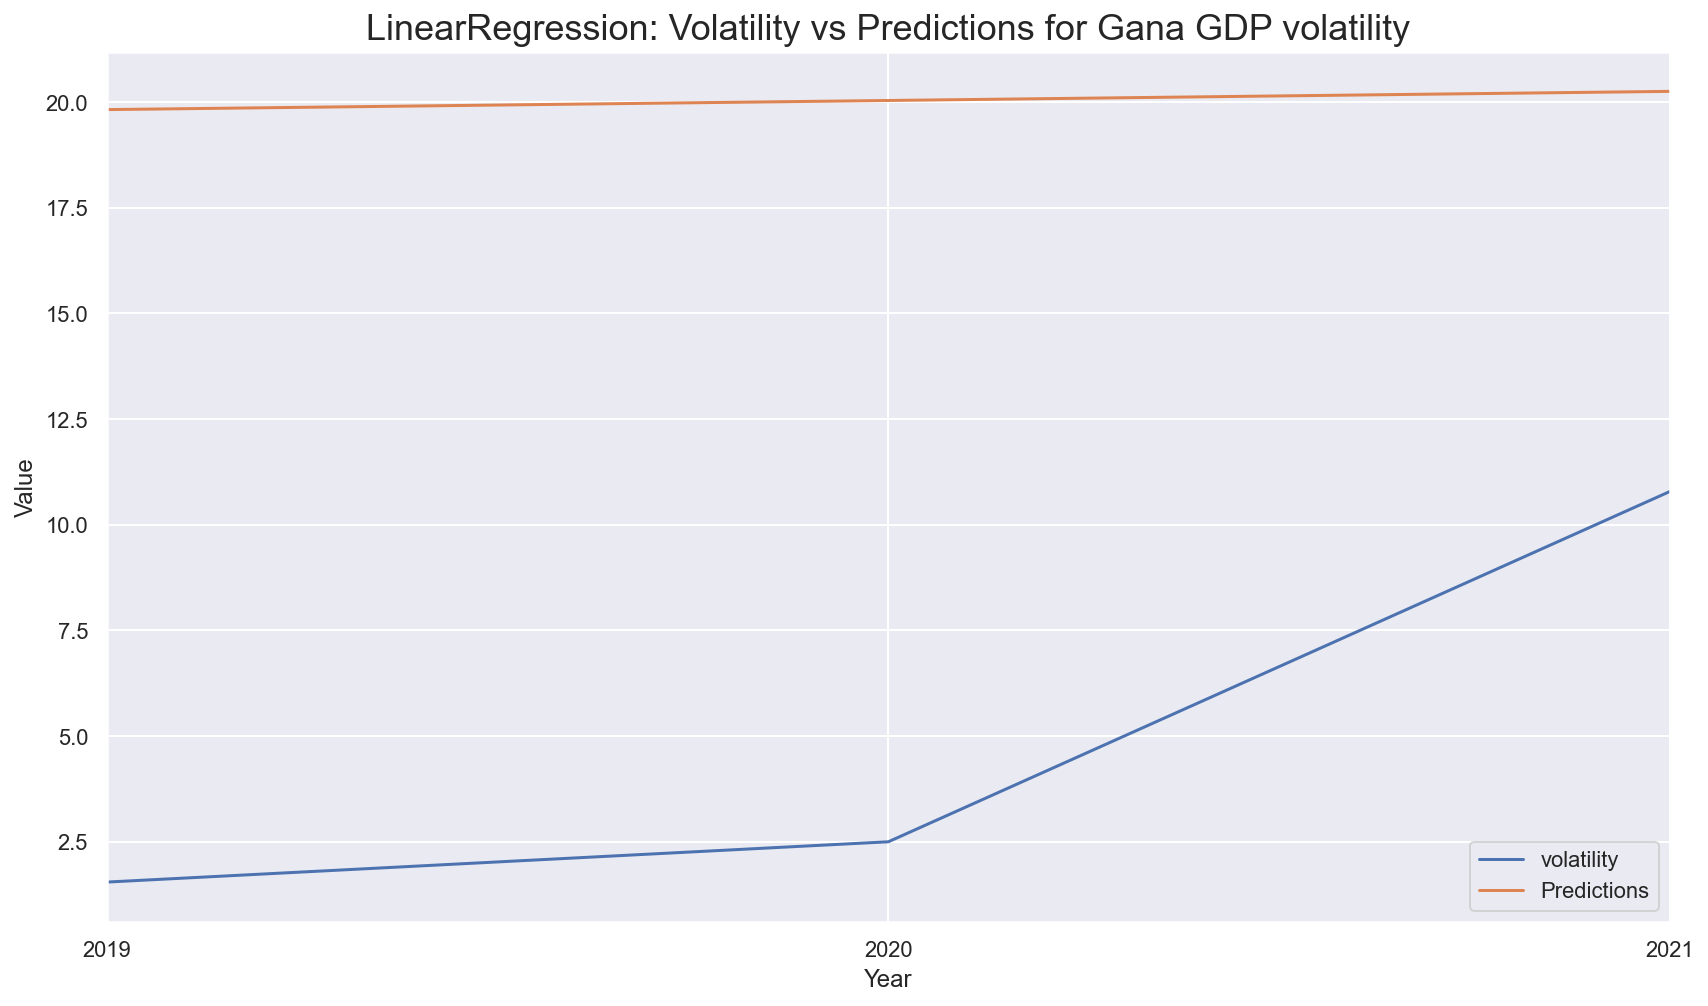

In [332]:
lr_prediction_df[['volatility', 'Predictions']].plot(kind='line', figsize=(14, 8))
plt.title('LinearRegression: Volatility vs Predictions for Gana GDP volatility', size=18)
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

In [333]:
print(f"LinearRegression on test MSE: {mean_squared_error(lr_prediction_df['volatility'], lr_prediction_df['Predictions']):.2f}")

LinearRegression on test MSE: 243.79


LR показывает по метрики MSE намного лучший результат.